In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
%matplotlib inline
#from __future__ import division
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pylab import *
pass

In [75]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

In [76]:
# Global definitions need for solutions.
#import jovian
import math
import numpy as np
import os
import re
import scipy.integrate
from scipy.constants import N_A
from scipy.optimize import curve_fit


In [77]:
import matplotlib.colors as mcolors
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('#FFFF33'), 0.15, c('#FFFF33'),c('#CC0000'), 0.3, c('#CC0000'),0.4, c('#CC0000'),c('#333399'),0.6,c('#333399'),0.7,c('#333399'),c('#3399FF'),0.8,c('#3399FF'),c('#66CCCC'),0.85,c('#66CCCC')])


# 1 simulator

$p$: probability of lysogeny

$m$: MOI

$l$: cell length

$h$: Hill coefficient

$K$: $K_A$

$N$: number of outputs

In [99]:
def Hill_equation(x,h,K):
    return x**h/(K**h+x**h)

def Bernoulli(x,p):
    if x > p:
        return 0
    else:
        return 1
Bernoulli=np.vectorize(Bernoulli)

def single_cell_decision_simulator(m,l,h,K,N): #the ZL2010 model
    p = (Hill_equation(m/l,h,K))**m
    return Bernoulli(np.random.uniform(0,1,N),p)

def single_cell_decision_simulator_2(m,l,h,K,N): #the wrong model (used to generate the last panel of Fig. 3A)
    p = Hill_equation(m/l,h,K)
    return Bernoulli(np.random.uniform(0,1,N),p)

def bootstrapping(x,num_resampling):
    x_mean = np.zeros(num_resampling);
    for i in range(0,num_resampling):
        x_mean[i] = np.mean(np.random.choice(x, len(x)))
    return (np.mean(x_mean), np.std(x_mean,ddof=1))
        
def bootstrapping_Hill_fit(xx, y, num_resampling): #for homogenerous numpy array
    h_list = np.zeros(num_resampling)
    K_list = np.zeros(num_resampling)
    y_list = np.zeros((6,num_resampling))
    for i in range(0,num_resampling):
        new_y = np.zeros(6)
        for j in range(1,6):
            new_n = np.random.choice(y[j,:],len(y[j,:]))
            new_y[j] = np.mean(new_n)
            y_list[j,i] = new_y[j]
        popt, pcov = curve_fit(Hill_equation, xx[1:], new_y[1:],p0=[1,1])
        h_list[i] = popt[0]
        K_list[i] = popt[1]
    y_list_mean = np.mean(y_list,axis=1)
    y_list_std = np.std(y_list,axis=1,ddof=1)
    return (y_list_mean, y_list_std, np.mean(h_list), np.std(h_list,ddof=1), np.mean(K_list), np.std(K_list,ddof=1))

def bootstrapping_Hill_fit_v2(xx, y, num_resampling): #for nonhomogenerous numpy array
    h_list = np.zeros(num_resampling)
    K_list = np.zeros(num_resampling)
    y_list = np.zeros((6,num_resampling))
    for i in range(0,num_resampling):
        new_y = np.zeros(6)
        for j in range(1,6):
            old_y = np.array(y[j]);
            new_n = np.random.choice(old_y,len(old_y))
            new_y[j] = np.mean(new_n)
            y_list[j,i] = new_y[j]
        popt, pcov = curve_fit(Hill_equation, xx[1:], new_y[1:],p0=[1,1])
        h_list[i] = popt[0]
        K_list[i] = popt[1]
    y_list_mean = np.mean(y_list,axis=1)
    y_list_std = np.std(y_list,axis=1,ddof=1)
    return (y_list_mean, y_list_std, np.mean(h_list), np.std(h_list,ddof=1), np.mean(K_list), np.std(K_list,ddof=1))

In [100]:
#parameters from the experiments
h = 2.07;
K = 1.17;

# 2 Reproduce LZ2010 figures

## 2.1 Reproduce Fig 2C

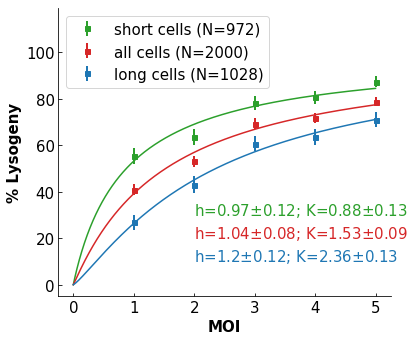

In [151]:
np.random.seed(1)

N_a = 0; N_s = 0; N_l = 0;  #counts

p_a = np.zeros((6,400)); 
p_s = np.empty((6,),dtype=object)
p_l = np.empty((6,),dtype=object)

l_all = np.zeros((6,400)) #lengths

for m in range(1,6):
    l_list = np.random.lognormal(0, 0.28, 400)
    l_all[m,:] = l_list
    t_s = np.array([])  #outcome (lysogeny or lysis) for short cells
    t_l = np.array([])  #outcome (lysogeny or lysis) for all cells
    t_a = np.array([])  #outcome (lysogeny or lysis) for long cells
    for l in l_list:
        tmp = single_cell_decision_simulator(m,l,h,K,1)
        t_a = np.append(t_a, tmp)
        if l > 1.0:
            t_l = np.append(t_l, tmp)
            N_l += 1;
        else:
            t_s = np.append(t_s, tmp)
            N_s += 1;
    p_a[m,:] = t_a;
    p_s[m] = t_s;
    p_l[m] = t_l;
        
#    m_s[m] = np.mean(t_s)
#    m_a[m] = np.mean(t_a)
#    m_l[m] = np.mean(t_l)

N_a = N_s + N_l
##################fit####################
xx = np.array(range(0,6))
xxx = np.linspace(0,5,1000)
num_resampling = 500;
(p_ma, p_ea, h_ma, h_ea, K_ma, K_ea) = bootstrapping_Hill_fit(xx, p_a, num_resampling);
(p_ms, p_es, h_ms, h_es, K_ms, K_es) = bootstrapping_Hill_fit_v2(xx, p_s, num_resampling);
(p_ml, p_el, h_ml, h_el, K_ml, K_el) = bootstrapping_Hill_fit_v2(xx, p_l, num_resampling);

##################plot####################
matplotlib.rcParams.update({"figure.figsize": (6,5)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plotStyles={"markersize":5,"markeredgewidth":1.0,"linewidth":2.0}

errorbar(xx[1:],p_ms[1:]*100,yerr=p_es[1:]*100,fmt='s',color='tab:green',label='short cells (N='+str(N_s)+')',**plotStyles)
plot(xxx,Hill_equation(xxx,h_ms,K_ms)*100,'-',color='tab:green')
text(2,30,'h='+str(round(h_ms,2))+r'$\pm$'+str(round(h_es,2))+'; K='+str(round(K_ms,2))+r'$\pm$'+str(round(K_es,2)),color='tab:green')

errorbar(xx[1:],p_ma[1:]*100,yerr=p_ea[1:]*100,fmt='s',color='tab:red',label='all cells (N='+str(N_a)+')',**plotStyles)
plot(xxx,Hill_equation(xxx,h_ma,K_ma)*100,'-',color='tab:red')
text(2,20,'h='+str(round(h_ma,2))+r'$\pm$'+str(round(h_ea,2))+'; K='+str(round(K_ma,2))+r'$\pm$'+str(round(K_ea,2)),color='tab:red')

errorbar(xx[1:],p_ml[1:]*100,yerr=p_el[1:]*100,fmt='s',color='tab:blue',label='long cells (N='+str(N_l)+')',**plotStyles)
plot(xxx,Hill_equation(xxx,h_ml,K_ml)*100,'-',color='tab:blue')
text(2,10,'h='+str(round(h_ml,2))+r'$\pm$'+str(round(h_el,2))+'; K='+str(round(K_ml,2))+r'$\pm$'+str(round(K_el,2)),color='tab:blue')

legend(loc='upper left')

ylim((-5,119))
xlabel('MOI',weight='bold'); ylabel('% Lysogeny',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")

tight_layout()

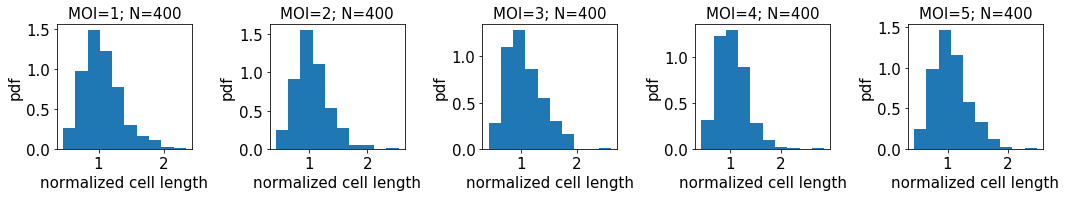

In [152]:
matplotlib.rcParams.update({"figure.figsize": (15,3)})
for i in range(1,6):
    subplot(1,5,i)
    hist(l_all[i],density=True)
    ylabel('pdf');xlabel('normalized cell length')
    title('MOI='+str(i)+'; N=400')
#    xscale('log')
tight_layout()

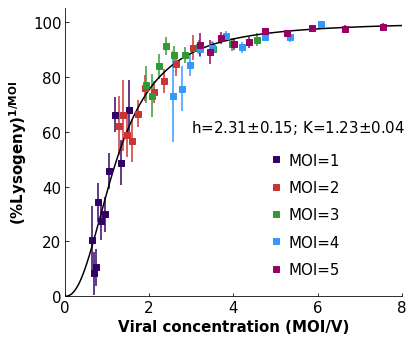

In [153]:
colors = ['#330066','#CC3333','#339933','#3399FF','#990066']

matplotlib.rcParams.update({"figure.figsize": (6,5)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

bin_l = [0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]
bin_h = [0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6]

x_ = np.array([])
y_ = np.array([])

num_resampling = 500;
for m in range(1,6):
    my_l = np.array(l_all[m,:]);
    my_p = np.array(p_a[m,:]);
    for i in range(0,len(bin_l)):
        indices1 = np.where(my_l>=bin_l[i])[0]
        indices2 = np.where(my_l<bin_h[i])[0]
        indices = list(set(indices1) & set(indices2))
        length = np.mean(my_l[indices])
        old_prob = my_p[indices]
        new_prob = np.zeros(num_resampling)
        for k in range(0,num_resampling):
            new_prob[k] = np.mean(np.random.choice(old_prob, len(old_prob)))**(1/m)
            x_ = np.append(x_, m/length)
            y_ = np.append(y_, new_prob[k])
        y_m = np.mean(new_prob)
        y_e = np.std(new_prob,ddof=1)
        errorbar(m/length,y_m*100,yerr=y_e*100,fmt='s',color=colors[m-1])

h_list=np.array([]);
K_list=np.array([]);
for i in range(0,int(len(x_)/500)):
    k = i;
    index = np.linspace(i,len(x_)+i-500,int(len(x_)/500))
    index = np.array(index).astype(int)
    popt, pcov = curve_fit(Hill_equation, x_[index], y_[index],p0=[1,1])
    h_list = np.append(h_list,popt[0])
    K_list = np.append(K_list,popt[1])
h_m = np.mean(h_list); h_e = np.std(h_list,ddof=1)
K_m = np.mean(K_list); K_e = np.std(K_list,ddof=1)

xx = np.linspace(0,8,1000)
plot(xx,Hill_equation(xx,h_m,K_m)*100,color='black')

xlim((0,8));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")

text(3,60,'h='+str(round(h_m,2))+r'$\pm$'+str(round(h_e,2))+'; K='+str(round(K_m,2))+r'$\pm$'+str(round(K_e,2)),color='black')
plot(5,50,'s',color=colors[0]); text(5.3,48,'MOI=1')
plot(5,40,'s',color=colors[1]); text(5.3,38,'MOI=2')
plot(5,30,'s',color=colors[2]); text(5.3,28,'MOI=3')
plot(5,20,'s',color=colors[3]); text(5.3,18,'MOI=4')
plot(5,10,'s',color=colors[4]); text(5.3,8,'MOI=5')
tight_layout()        


## 2.2 Reproduce Fig 3A

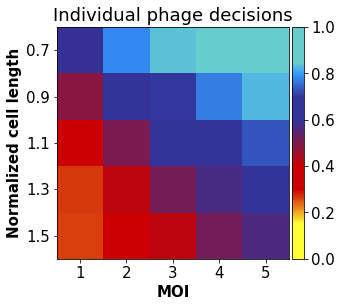

In [21]:
N = 1000;
m_list = [1,2,3,4,5]
l_list = [0.7, 0.9, 1.1, 1.3,1.5]
output1 = np.zeros((len(m_list),len(l_list)))
output2 = np.zeros((len(m_list),len(l_list)))
for i in range(0,len(m_list)):
    for j in range(0,len(l_list)):
        tmp1=single_cell_decision_simulator(m_list[i],l_list[j],h,K,N)
        tmp2=single_cell_decision_simulator_2(m_list[i],l_list[j],1.0,K,N)
        output1[i,j] = np.mean(tmp1)
        output2[i,j] = np.mean(tmp2)

matplotlib.rcParams.update({"figure.figsize": (5,5)})
fig, ax = plt.subplots(1,1)
img = ax.imshow(output1.T,vmin=0, vmax=1, cmap=rvb,interpolation='none')
#plot x and y label
x_label_list = ['1', '2', '3', '4','5']; y_label_list = ['0.7', '0.9', '1.1', '1.3','1.5']
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(y_label_list)
ax.set_xlabel('MOI',weight='bold')
ax.set_ylabel('Normalized cell length',weight='bold')

#display values
#for (i, j), z in np.ndenumerate(output2.T):
#    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

#adjust color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img,cax=cax)
ax.set_title('Individual phage decisions',fontsize=18)
tight_layout()

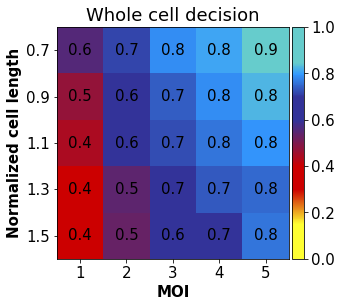

In [22]:
matplotlib.rcParams.update({"figure.figsize": (5,5)})
fig, ax = plt.subplots(1,1)
img = ax.imshow(output2.T,vmin=0, vmax=1, cmap=rvb,interpolation='none')

#plot x and y label
x_label_list = ['1', '2', '3', '4','5']; y_label_list = ['0.7', '0.9', '1.1', '1.3','1.5']
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(y_label_list)
ax.set_xlabel('MOI',weight='bold')
ax.set_ylabel('Normalized cell length',weight='bold')

#display values
for (i, j), z in np.ndenumerate(output2.T):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
ax.set_title('Whole cell decision')

#adjust color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img,cax=cax)
ax.set_title('Whole cell decision',fontsize=18)
tight_layout()

## 2.3 Reproduce Fig 3C

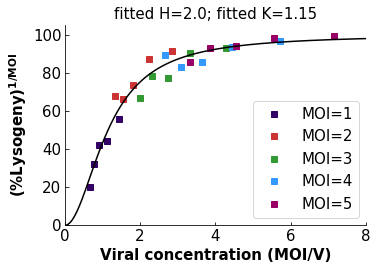

In [23]:
colors = ['#330066','#CC3333','#339933','#3399FF','#990066']

matplotlib.rcParams.update({"figure.figsize": (5.5,4)})
fig, ax = plt.subplots()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

x__ = np.array([])
y__ = np.array([])
for i in range(0,len(m_list)):
    x_ = np.array([])
    y_ = np.array([])
    for j in range(0,len(l_list)):
        N = 50;
        tmp1=single_cell_decision_simulator(m_list[i],l_list[j],h,K,N)
        x_ = np.append(x_,m_list[i]/l_list[j])
        y_ = np.append(y_, (np.mean(tmp1))**(1/m_list[i]))
    plot(x_,y_*100,'s',color=colors[i],label='MOI='+str(m_list[i]))
    x__ = np.append(x__, x_)
    y__ = np.append(y__, y_)

index__ = np.argsort(x__)
x__ = x__[index__]
y__ = y__[index__]
popt, pcov = curve_fit(Hill_equation, x__, y__)
title('fitted H='+str(round(popt[0],2))+'; fitted K='+str(round(popt[1],2)))

xx = np.linspace(0,8,1000)
plot(xx,Hill_equation(xx,*popt)*100,color='black')

xlim((0,8));ylim((0,105))
xlabel('Viral concentration (MOI/V)',weight='bold'); ylabel(r'$\mathbf{(\% Lysogeny)^{1/MOI}}$',weight='bold')
tick_params(axis="y",direction="in")
tick_params(axis="x",direction="in")

legend()
tight_layout()

In [24]:
#jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/gengyuncong/1-simulator


'https://jovian.ml/gengyuncong/1-simulator'